# Fastdup Tutorial

[Visit our GitHub Project Page](https://github.com/visualdatabase/fastdup)

## Install fastdup

In [2]:
!pip install -U fastdup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 39.2 MB 1.2 MB/s 
  Attempting uninstall: fastdup
    Found existing installation: fastdup 0.65
    Uninstalling fastdup-0.65:
      Successfully uninstalled fastdup-0.65


In [3]:
import fastdup

In [4]:
fastdup.__version__

'0.68'

## Download the food-101 dataset

In [5]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2022-06-11 18:25:10--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2022-06-11 18:25:10--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  45.6MB/s    in 1m 53s  

2022-06-11 18:27:02 (42.3 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [10]:
!tar xzf food-101.tar.gz

## Run fastdup to gain insights from your data

In [5]:
fastdup.run('food-101')

Going to loop over dir food-101
Found total 101000 images to run on
[■                                                 ] 1% Estimated: 0 Minutes
Wrote  total of 101000 features, found 0 bad images
Found total 101000 images to run on
122) Finished write_index() faiss
Stored faiss index file ./faiss.index
1654973893 : INFO:     (add_vertices:460): Num vertices for group 0: 101000
1654973893 : INFO:     (commit_edge_buffer:609): In commit edge buffer (0,0)
1654973893 : INFO:     (commit_edge_buffer:680): Shuffling edges ...
1654973893 : INFO:     (commit_edge_buffer:688): Done shuffling edges in 0.007024 secs
1654973893 : INFO:     (commit_edge_buffer:692): Aggregating unique vertices...
1654973893 : INFO:     (commit_edge_buffer:705): Done aggregating unique vertex in 0.001154 secs
1654973893 : INFO:     (commit_edge_buffer:713): Combine vertex data
1654973893 : INFO:     (commit_edge_buffer:779): Done phase 2 in 0.017599 secs
1654973893 : INFO:     (commit_edge_buffer:787): Rename id co

In [6]:
fastdup.create_duplicates_gallery('similarity.csv',save_path='.', num_images=20)

100%|██████████| 20/20 [00:00<00:00, 54.78it/s]


Stored similarity visual view in  ./similarity.html



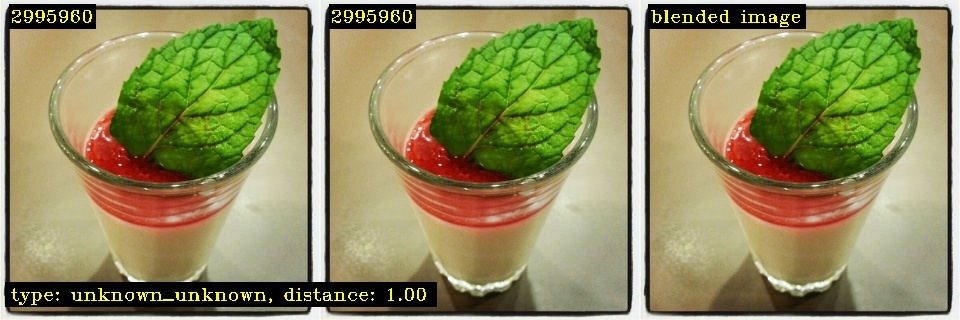
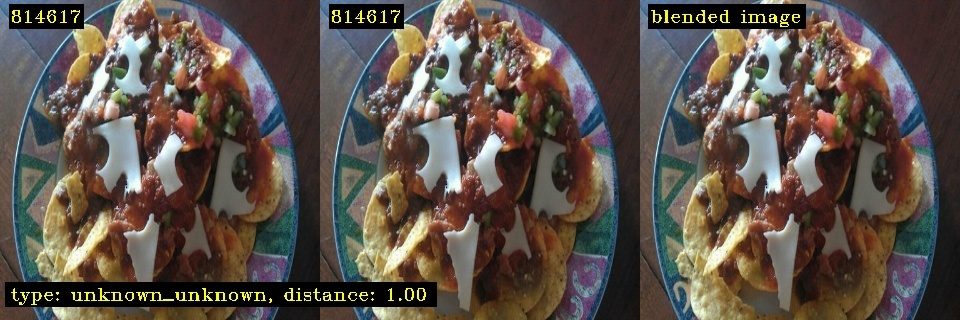
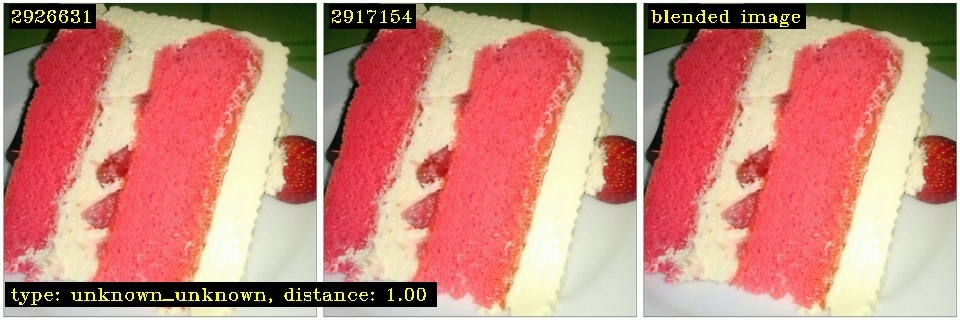
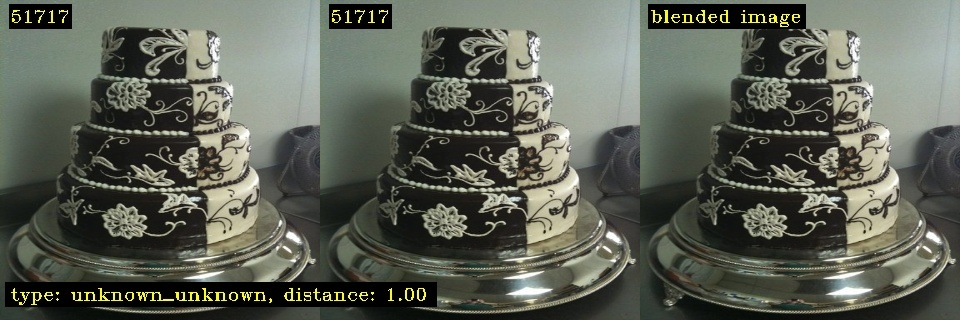
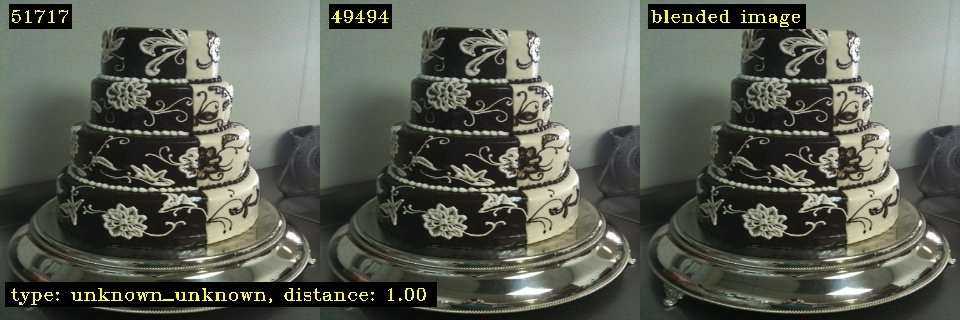
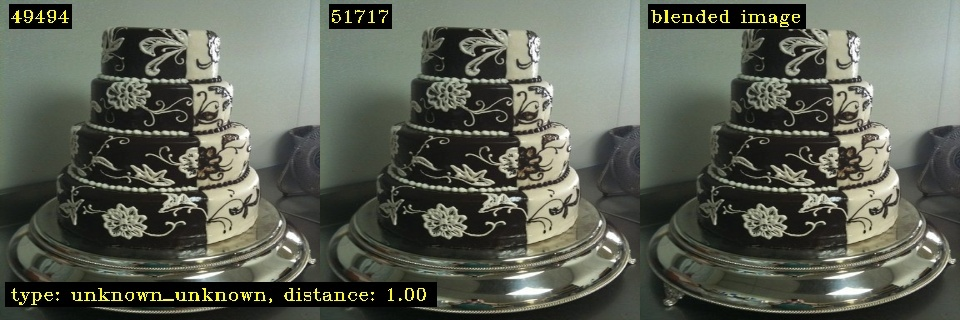
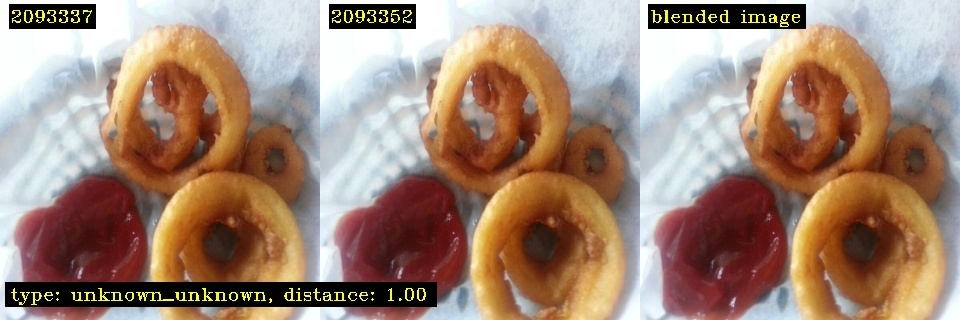
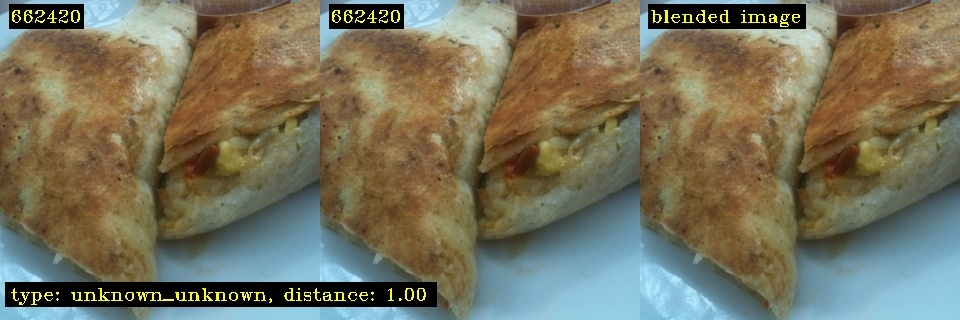
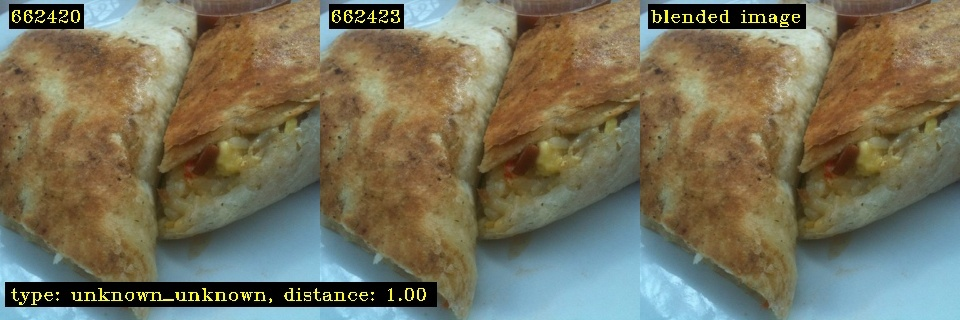
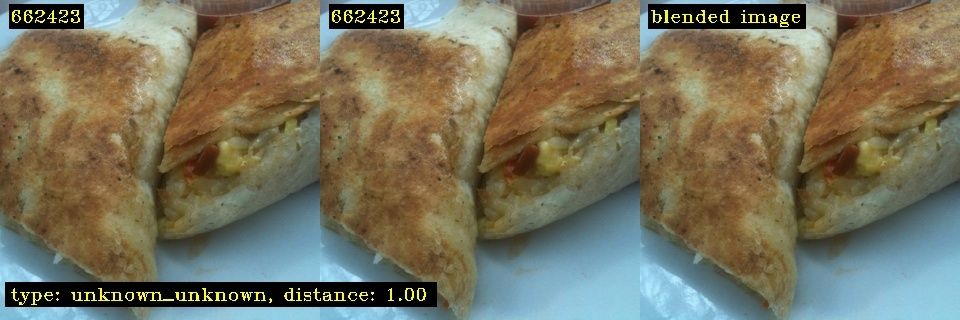
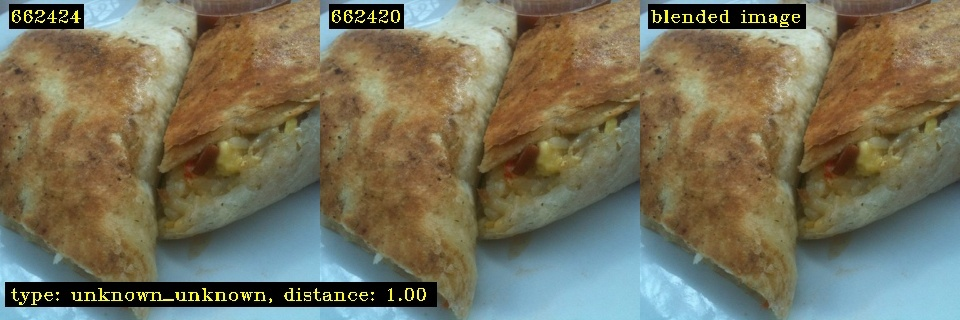
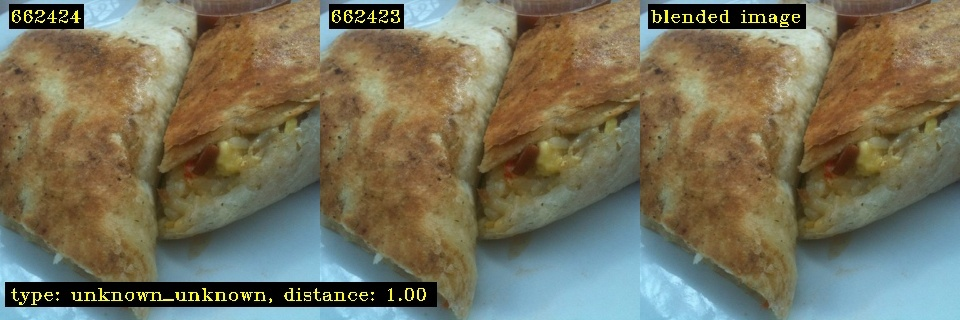
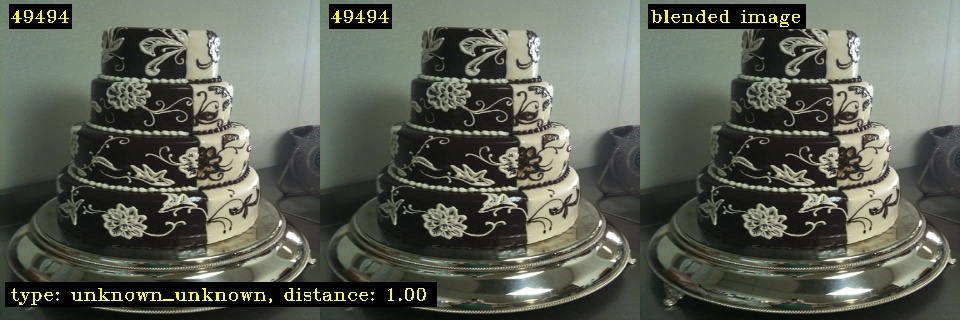
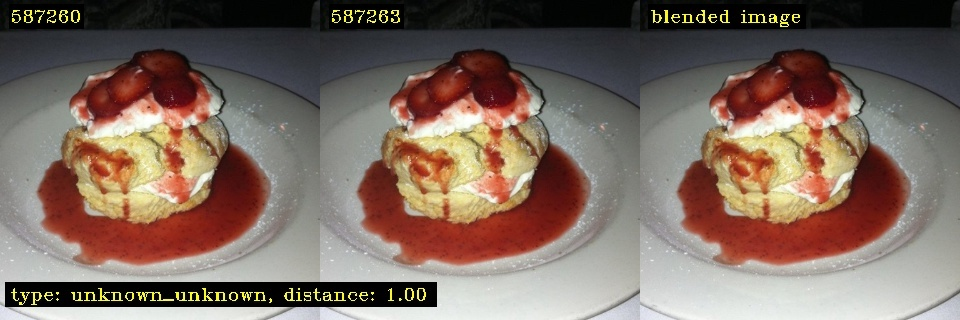
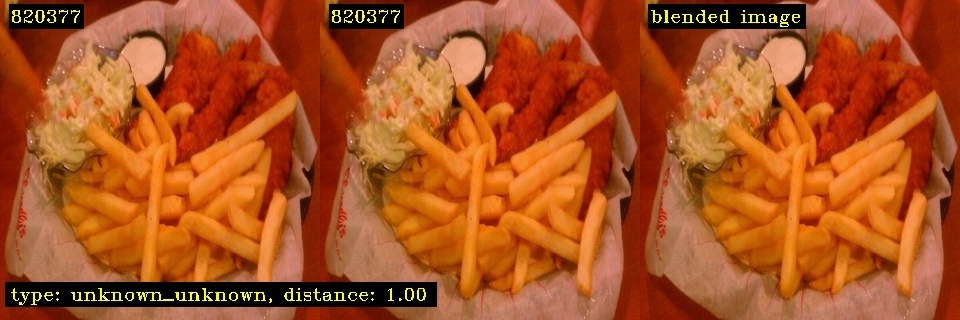
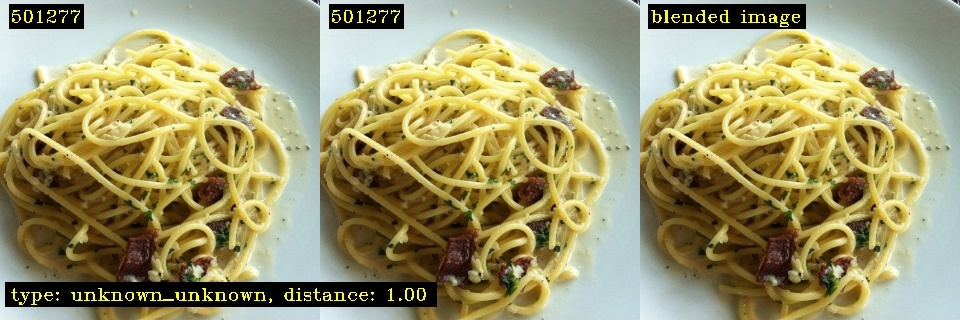
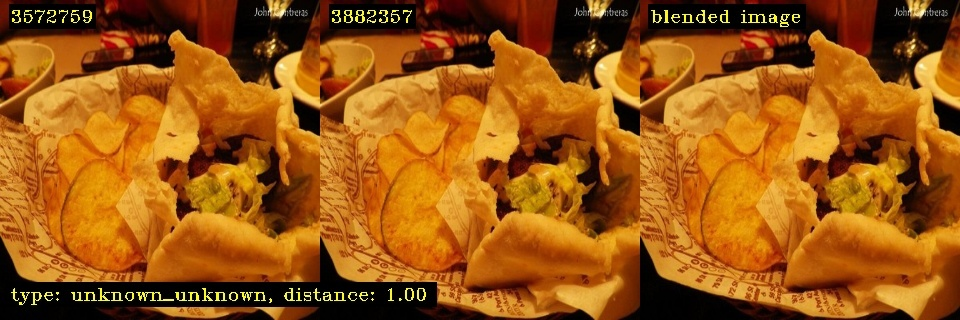
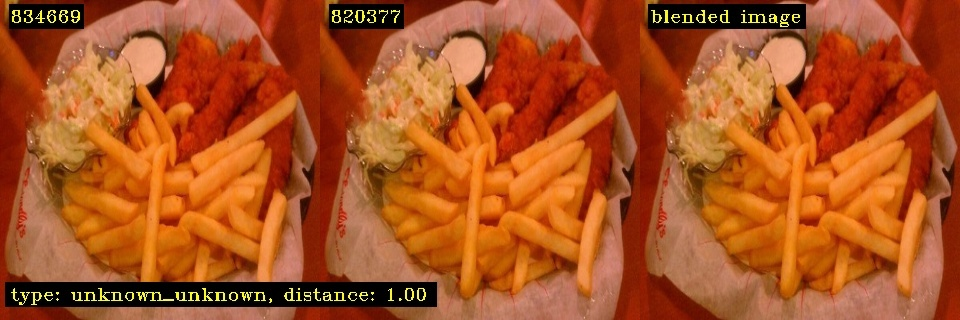
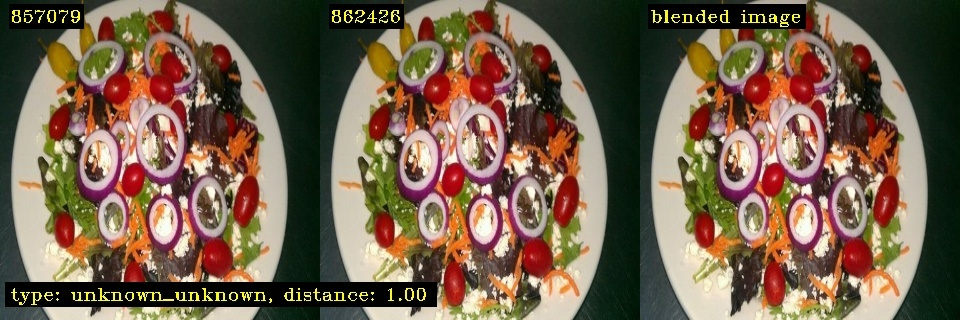
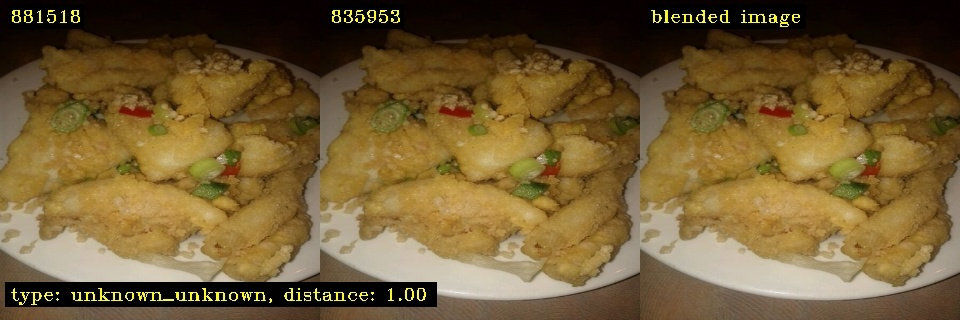

In [7]:
from IPython.display import HTML
HTML('similarity.html')

In [8]:
fastdup.create_outliers_gallery('outliers.csv',save_path='.', num_images=20)

100%|██████████| 20/20 [00:00<00:00, 172.81it/s]

Stored outliers visual view in  ./outliers.html



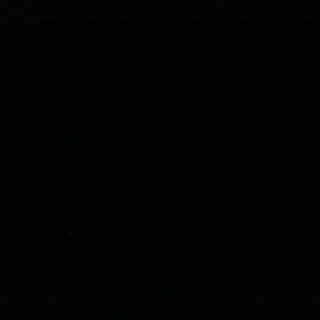
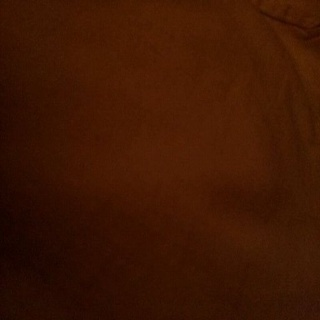
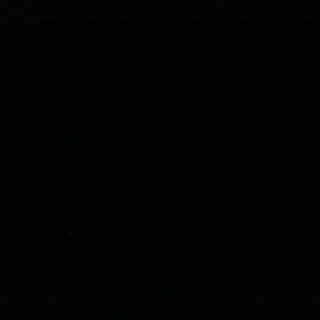
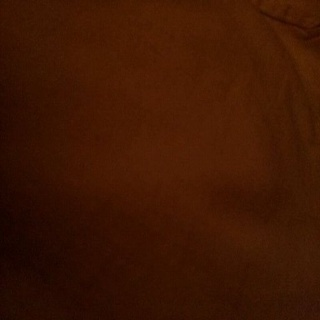
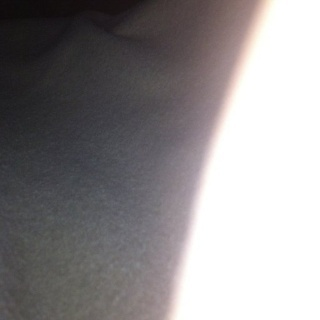
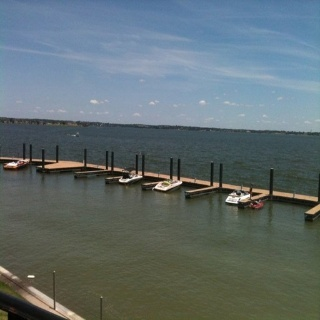
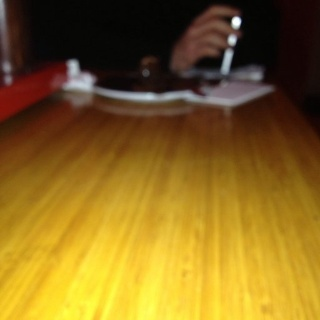
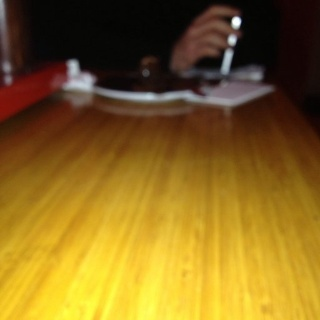
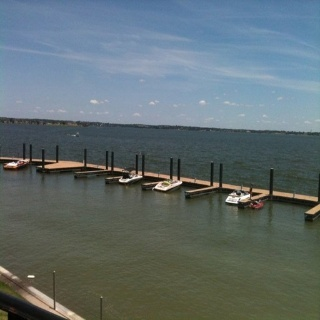
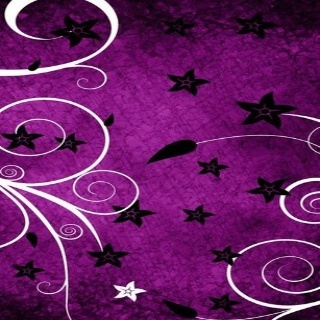
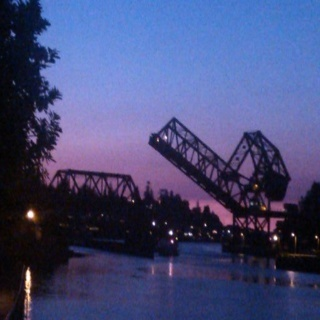
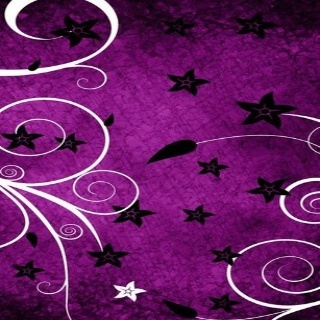
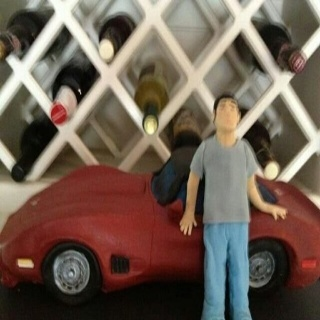
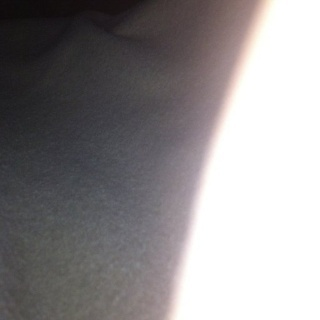
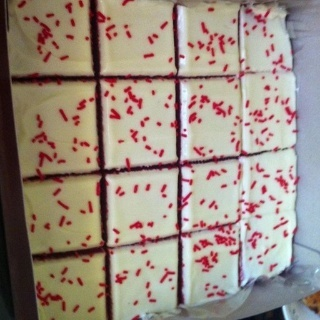
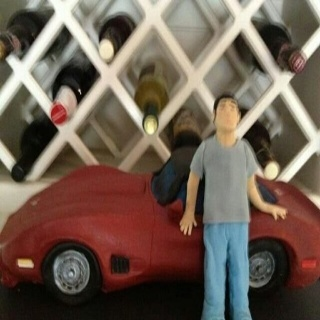
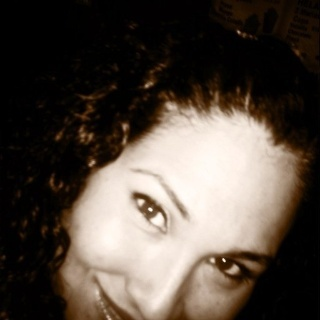
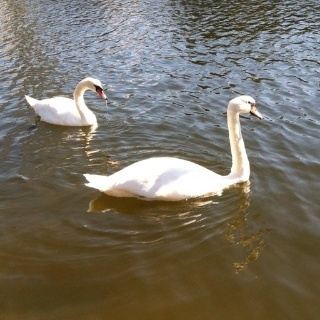
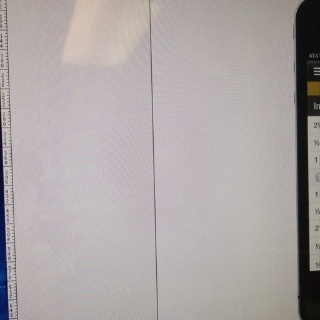
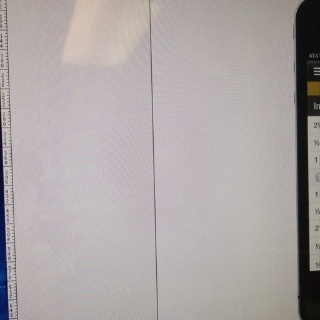

In [9]:
HTML('outliers.html')

## Perform graph analytics to find connected components of images

Connected components are clusters of similar images. In the code below we find the largest clusters of duplicate images and visualize them.

In [30]:
import pandas as pd
import os

def find_largest_components(work_dir):
  # read fastdup connected components, for each image id we get component id
  components = pd.read_csv(os.path.join(work_dir, 'connected_components.csv'))
  # read fastdup image file list. For each id we get image name
  filenames = pd.read_csv(os.path.join(work_dir, 'features.dat.csv'))
  assert len(components) == len(filenames)
  # now join the two tables to get both id and image name
  components['filename'] = filenames['filename']

  # find the components that have the largest number of images included
  top_components = components.groupby('component_id')['filename'].apply(list)
  comps = pd.DataFrame({'files':top_components}).reset_index()
  comps['len'] = comps['files'].apply(lambda x: len(x))
  comps = comps.sort_values('len', ascending=False)
  return comps


In [31]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from IPython.display import Image
import traceback

In [32]:

NUM_COMPONENTS_TO_PLOT = 5
MAX_IMAGES_IN_GRID = 48

top_components = find_largest_components(work_dir='.')

# iterate over the top components
for i,row in top_components.head(NUM_COMPONENTS_TO_PLOT).iterrows():
    try:
        # find the component id
        component_id = row['component_id']
        # find all the image filenames linked to this id
        files = row['files'][:MAX_IMAGES_IN_GRID]

        fig = plt.figure(figsize=(10,8))
        images = []
        for f in files:
            img = PILImage.open(f).convert('RGB').resize((300,300))
            transform = transforms.Compose([transforms.PILToTensor()])
            tensor = transform(img)
            images.append(tensor)

        # make a grid image of all components
        grid = make_grid(images, nrow=12, padding=3)
        plt.imshow(np.transpose(grid, (1, 2, 0)), interpolation='nearest')
     
        # plot the image
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        plt.title('Components ' + str(i) + "\n" + str([os.path.basename(x) for x in files]))
        plt.savefig('component' + str(i) + '.png', bbox_inches='tight', pad_inches=0.1)
        plt.close(fig)
        plt.clf() 
        
    except Exception as ex:
        print('Failed on component', i, ex)
        traceback.print_exc()
    

<Figure size 432x288 with 0 Axes>

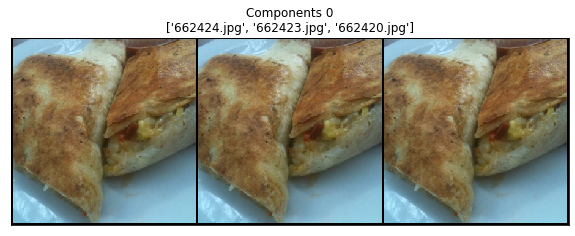

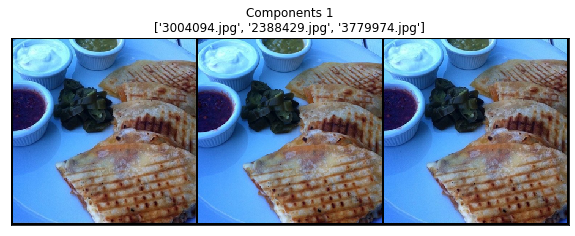

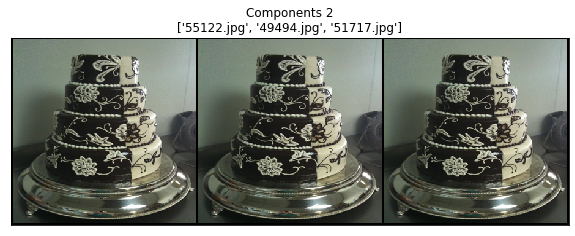

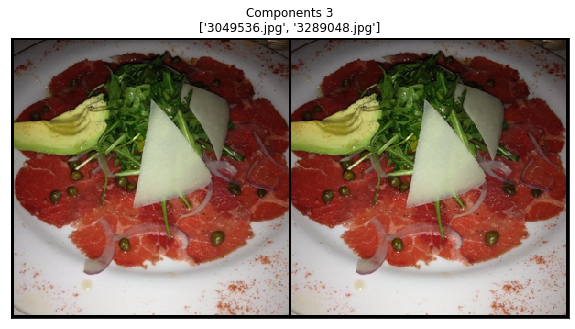

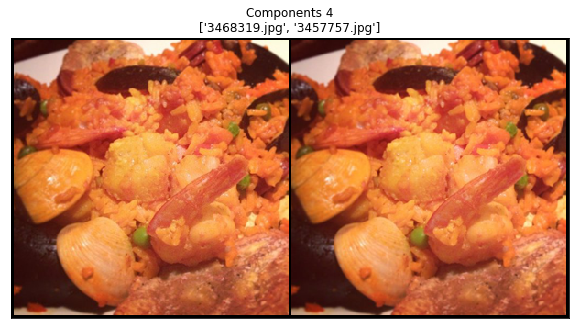

In [33]:
# displaay top components
for i in range(NUM_COMPONENTS_TO_PLOT):
  display(Image(filename=f'component{i}.png'))